In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium.plugins import HeatMap
from datetime import datetime
import numpy as np
from IPython.display import HTML

# Plot temperatures over time

In [87]:
file_path = 'temps.txt'

rate = 10 #in Hz, rate we're capturing data
window_secs = 10
window_size = 2*window_secs*rate

df = pd.read_csv(file_path, parse_dates=['datetime'])

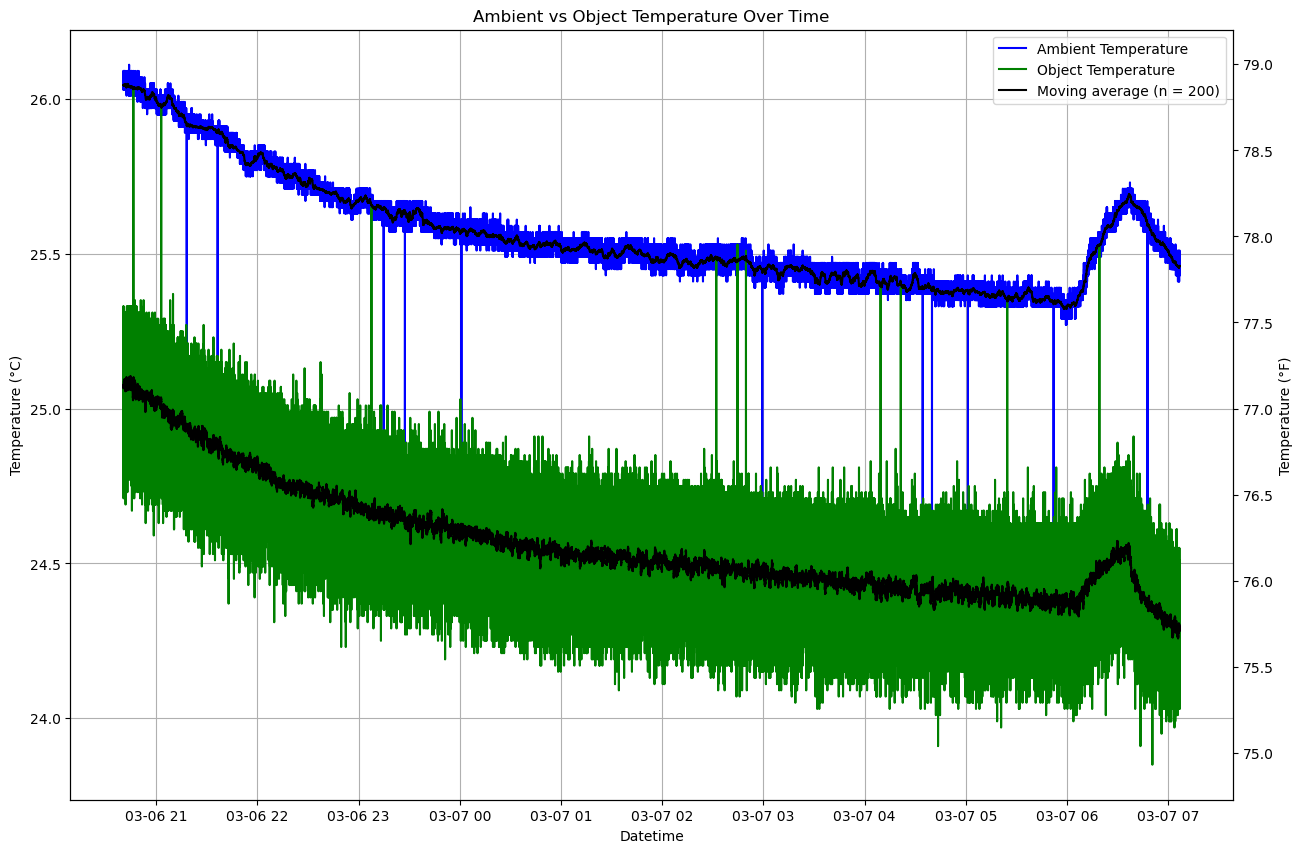

In [88]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(df['datetime'], df['ambient_temperature'], label='Ambient Temperature', color='blue')
ax1.plot(df['datetime'], df['object_temperature'], label='Object Temperature', color='green')
ax1.set_xlabel('Datetime')
ax1.set_ylabel(
    'Temperature (°C)')
ax1.legend()
df['ambient_temperature_moving_avg'] = df['ambient_temperature'].rolling(window=window_size, center=True).mean()
df['object_temperature_moving_avg'] = df['object_temperature'].rolling(window=window_size, center=True).mean()
df['temperature_dif'] = df['ambient_temperature'] - df['object_temperature']
df['t'] = df['datetime'] - df['datetime'].min()

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature (°F)')
celsius_limits = ax1.get_ylim()
ax2.set_ylim(celsius_limits[0] * 9/5 + 32, celsius_limits[1] * 9/5 + 32)

moving_avg_label = 'Moving average (n = '+str(window_size) + ")"
ax1.plot(df['datetime'], df['ambient_temperature_moving_avg'], color='black', linestyle='-')

ax1.plot(df['datetime'], df['object_temperature_moving_avg'], label=moving_avg_label, color='black', linestyle='-')
ax1.grid(True)
ax1.legend()
plt.title('Ambient vs Object Temperature Over Time')
plt.show()

In [65]:
df.describe()#.to_latex()

,datetime,ambient_temperature,object_temperature,latitude,longitude,altitude,ambient_temperature_moving_avg,object_temperature_moving_avg,temperature_dif,t
count,375928,375928.000000,375928.000000,375928.0,375928.0,375928.0,374929.000000,374929.000000,375928.000000,375928
mean,2024-03-07 01:53:38.969506304,25.564703,24.566307,-1.0,-1.0,-1.0,25.564207,24.565991,0.998397,0 days 05:13:16.350354493
min,2024-03-06 20:40:22.619151,24.210000,23.850000,-1.0,-1.0,-1.0,25.324640,24.282240,-0.120000,0 days 00:00:00
25%,2024-03-06 23:17:00.794498560,25.430000,24.430000,-1.0,-1.0,-1.0,25.434060,24.431040,0.920000,0 days 02:36:38.175347500
50%,2024-03-07 01:53:38.969483008,25.510000,24.530000,-1.0,-1.0,-1.0,25.515760,24.514740,1.000000,0 days 05:13:16.350332
75%,2024-03-07 04:30:17.144531456,25.650000,24.690000,-1.0,-1.0,-1.0,25.652740,24.657920,1.080000,0 days 07:49:54.525380500
max,2024-03-07 07:06:55.319535,26.110000,26.030000,-1.0,-1.0,-1.0,26.044040,25.088720,1.720000,0 days 10:26:32.700384
std,NaN,0.178744,0.208595,0.0,0.0,0.0,0.177355,0.179001,0.118366,0 days 03:00:52.121033606


In [68]:
length = df['datetime'].max() - df['datetime'].min()
print(length)

0 days 10:26:32.700384


# Plot temperatures for each location

In [6]:
np.random.seed(0) 
n = 100  # num of data points
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()  # lat range 
lon_min, lon_max = df['longitude'].min(), df['longitude'].max() # long range

#make folium map
map_princeton = folium.Map(control_scale=True, location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],tiles="Esri.WorldImagery") # zoom_start=11, 

#add a heat map layer based on object_temperature values
heat_data = [[row['latitude'], row['longitude'], row['object_temperature']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(map_princeton)

colormap = folium.LinearColormap(colors=['blue', 'cyan', 'lime', 'yellow', 'red'], vmin=min(df['object_temperature'])-0.5, vmax=max(df['object_temperature'])+0.5, caption='Object Temperature (°C)')
map_princeton.add_child(colormap)



#datetime range to mark on map
df['datetime'] = pd.to_datetime(df['datetime'])
datetime_range = f"{df['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')} to {df['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')}"

caption_html = f"""
<div style='position: fixed; 
     top: 50px; left: 50px;
     background-color: white; padding: 10px; 
     z-index:9999; font-size:14px;'>
     Datetime Range: {datetime_range}
</div>
"""
map_princeton.get_root().html.add_child(folium.Element(caption_html))

# save the map to an HTML file, make it openable
map_princeton.save('princeton_heatmap.html')
HTML(f'<a href="{"princeton_heatmap.html"}" target="_blank">Access map here</a>')
#map_princeton

# Plot map for detections

In [24]:
file_path = 'detections.txt'
data = pd.read_csv(file_path, parse_dates=['datetime'])
data[:10]

,datetime,fname,label,confidence,latitude,longitude,altitude
0,2024-03-06 19:02:22.257062,NaN,shark,0.958603,30.69,-72.69,30.0
1,2024-03-06 19:02:22.259992,NaN,shark,0.900573,30.69,-72.69,30.0
2,2024-03-06 19:02:24.452791,NaN,shark,0.958603,30.69,-72.69,30.0
3,2024-03-06 19:02:24.454546,NaN,shark,0.900573,30.69,-72.69,30.0
4,2024-03-06 19:02:26.823282,NaN,shark,0.958603,30.69,-72.69,30.0
5,2024-03-06 19:02:26.825112,NaN,shark,0.900573,30.69,-72.69,30.0
6,2024-03-06 19:02:29.078024,NaN,shark,0.958603,30.69,-72.69,30.0
7,2024-03-06 19:02:29.080774,NaN,shark,0.900573,30.69,-72.69,30.0
8,2024-03-06 19:02:31.349375,NaN,shark,0.958603,30.69,-72.69,30.0
9,2024-03-06 19:02:31.351096,NaN,shark,0.900573,30.69,-72.69,30.0


In [88]:

# Load the data
file_path = 'detections.txt'
data = pd.read_csv(file_path, parse_dates=['datetime'])

# init map
map2 = folium.Map(control_scale=True, location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=13, tiles="Esri.WorldImagery")

# images for a popup
img_url = 'https://www.fisheries.noaa.gov/s3/styles/original/s3/2023-06/750x500-Great-White-iStock.jpg'
html_content = f"<div style='width: 100%; max-width: 1200px;'><img src='{img_url}' alt='Image' style='width:100%;'></div>"

# add markers
for i in range(len(data)):
    print(data.iloc[i])
    if data.iloc[i]['label'] == 'shark':
        html_content = f"""
        <div style='width: 100%; max-width: 1200px;'>
            <p>Confidence: {data.iloc[i]['confidence']}</p>
            <p>Latitude: {data.iloc[i]['latitude']}</p>
            <p>Longitude: {data.iloc[i]['longitude']}</p>
            <p>Altitude: {data.iloc[i]['altitude']}</p>
            <p>Datetime: {data.iloc[i]['datetime']}</p>
            <p>File name: {data.iloc[i]['fname']}</p>
        </div>
        """
        iframe = folium.IFrame(html=html_content, width=300, height=200)  # Adjust width and height as needed
        popup = folium.Popup(iframe, max_width=300)
        folium.Marker(
            location=[data.iloc[i]['latitude'], data.iloc[i]['longitude']],
            popup=popup,
            tooltip=data.iloc[i]['label'],
            icon=folium.Icon(icon='fa-fish', prefix='fa', color='blue')
        ).add_to(map2)

# save map
map2.save('map2.html')

# display
HTML(f'<a href="{"map2.html"}" target="_blank">Access map here</a>')

datetime      2024-03-06 19:02:22.257062
fname                                NaN
label                              shark
confidence                      0.958603
latitude                           30.69
longitude                         -72.69
altitude                            30.0
Name: 0, dtype: object
datetime      2024-03-06 19:02:22.259992
fname                                NaN
label                              shark
confidence                      0.900573
latitude                           30.69
longitude                         -72.69
altitude                            30.0
Name: 1, dtype: object
datetime      2024-03-06 19:02:24.452791
fname                                NaN
label                              shark
confidence                      0.958603
latitude                           30.69
longitude                         -72.69
altitude                            30.0
Name: 2, dtype: object
datetime      2024-03-06 19:02:24.454546
fname                        